In [10]:
'''This is a simple example of implementing a vectorized backtesting infrastructure where I've created an 
object-oriented research-based backtesting environment and tested it on moving average cross over strategy.
It reports few important performance metrics such as sharpe ratio,drawdown amounts,max drawdown and drawdown duration
It plots equity  as well as drawdown curve
Analysis also includes paramater optimization.Backtest_portfolio method from Portfolio class computes a return 
vector for a particular short and long term lookback periods  over a grid of parameters'''

import pandas as pd
import string
import numpy as np
import random
import matplotlib.pyplot as plt 
import seaborn as sns
from pandas.tools.plotting import scatter_matrix 
from scipy.stats import f_oneway, ttest_ind
import warnings
warnings.filterwarnings('ignore') 
from IPython.display import display
import random; random.seed(0)
import string
import os
import pandas_datareader.data as web
from IPython.display import display
# various options in pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 25)
pd.set_option('display.precision', 3)
plt.rcParams['figure.figsize'] = (15, 4)
path='/Users/aybarsatalay/Desktop/Python'
os.chdir(path)


from abc import ABCMeta, abstractmethod

class Strategy(object):
    """Strategy is an abstract base class providing an interface for
    all subsequent (inherited) trading strategies.

    The goal of a (derived) Strategy object is to output a list of signals,
    which has the form of a time series indexed pandas DataFrame.

    In this instance only a single symbol/instrument is supported."""

    __metaclass__ = ABCMeta

    @abstractmethod
    def generate_signals(self):
        """An implementation is required to return the DataFrame of symbols 
        containing the signals to go long, short or hold (1, -1 or 0)."""
        raise NotImplementedError("Should implement generate_signals()!")



# ma_cross.py

class MovingAverageCrossStrategy(Strategy):
    """    
    Requires:
    symbol - A stock symbol on which to form a strategy on.
    bars - A DataFrame of bars for the above symbol.
    short_window - Lookback period for short moving average.
    long_window - Lookback period for long moving average."""

    def __init__(self, symbol, bars, short_window=8, long_window=32):
        self.symbol = symbol
        self.bars = bars

        self.short_window = short_window
        self.long_window = long_window

    def generate_signals(self):
        """Returns the DataFrame of symbols containing the signals
        to go long, short or hold (1, -1 or 0)."""
        signals = pd.DataFrame(index=self.bars.index)
        signals['signal'] = 0.0

        # Create the set of short and long simple moving averages over the 
        # respective periods
        signals['short_mavg'] = pd.rolling_mean(self.bars['Adj Close'], self.short_window, min_periods=1)
        signals['long_mavg'] = pd.rolling_mean(self.bars['Adj Close'], self.long_window, min_periods=1)

        # Create a 'signal' (invested or not invested) when the short moving average crosses the long
        # moving average, but only for the period greater than the shortest moving average window
        signals['signal'][self.short_window:] = np.where(signals['short_mavg'][self.short_window:] 
            < signals['long_mavg'][self.short_window:], 1.0, 0.0)   

        # Take the difference of the signals in order to generate actual trading orders
        signals['positions'] = signals['signal'].diff()   

        return signals
        
# backtest.py

class Portfolio(object):
    """An abstract base class representing a portfolio of 
    positions (including both instruments and cash), determined
    on the basis of a set of signals provided by a Strategy."""

    __metaclass__ = ABCMeta

    @abstractmethod
    def generate_positions(self):
        """Provides the logic to determine how the portfolio 
        positions are allocated on the basis of forecasting
        signals and available cash."""
        raise NotImplementedError("Should implement generate_positions()!")

    @abstractmethod
    def backtest_portfolio(self):
        """Provides the logic to generate the trading orders
        and subsequent equity curve (i.e. growth of total equity),
        as a sum of holdings and cash, and the bar-period returns
        associated with this curve based on the 'positions' DataFrame.

        Produces a portfolio object that can be examined by 
        other classes/functions."""
        raise NotImplementedError("Should implement backtest_portfolio()!")
        
# ma_cross.py

class MarketOnClosePortfolio(Portfolio):
    """Encapsulates the notion of a portfolio of positions based
    on a set of signals as provided by a Strategy.

    Requires:
    symbol - A stock symbol which forms the basis of the portfolio.
    bars - A DataFrame of bars for a symbol set.
    signals - A pandas DataFrame of signals (1, 0, -1) for each symbol.
    initial_capital - The amount in cash at the start of the portfolio."""

    def __init__(self, symbol, bars, signals, initial_capital=100000.0):
        self.symbol = symbol        
        self.bars = bars
        self.signals = signals
        self.initial_capital = float(initial_capital)
        self.positions = self.generate_positions()
        
    def generate_positions(self):
        positions = pd.DataFrame(index=signals.index).fillna(0.0)
        positions[self.symbol] = 100*signals['signal']   # This strategy buys 100 shares
        return positions
                    
    def backtest_portfolio(self):
        portfolio = self.positions.multiply(self.bars['Adj Close'],axis=0)
        pos_diff = self.positions.diff()
        
        
        portfolio['signals']=self.signals['signal']
        portfolio['short']=self.signals['short_mavg']
        portfolio['long']=self.signals['long_mavg']
        portfolio['price']=self.bars['Adj Close']
        portfolio['holdings'] = self.positions.multiply(self.bars['Adj Close'],axis=0).sum(axis=1)
        portfolio['cash'] = self.initial_capital - (pos_diff.multiply(self.bars['Adj Close'],axis=0)).sum(axis=1).cumsum()

        portfolio['total'] = portfolio['cash'] + portfolio['holdings']
        portfolio['returns'] = portfolio['total'].pct_change()
        return portfolio
    
    


def annualised_sharpe(returns, N=252):

    return np.sqrt(N) * (returns.mean()/5.0) / returns.std()


def create_drawdowns(pnl):
    """
    Calculate the largest peak-to-trough drawdown of the PnL curve
    as well as the duration of the drawdown. Requires that the 
    pnl_returns is a pandas Series.

    Parameters:
    pnl - A pandas Series representing period percentage returns.

    Returns:
    drawdown, duration - Highest peak-to-trough drawdown and duration.
    """

    # Calculate the cumulative returns curve 
    # and set up the High Water Mark
    hwm = [0]

    # Create the drawdown and duration series
    idx = pnl.index
    drawdown = pd.Series(index = idx)
    duration = pd.Series(index = idx)

    # Loop over the index range
    for t in range(1, len(idx)):
        hwm.append(max(hwm[t-1], pnl[t]))
        drawdown[t]= (hwm[t]-pnl[t])
        duration[t]= (0 if drawdown[t] == 0 else duration[t-1]+1)
    return drawdown, drawdown.max(), duration.max()
        



[('Sharpe Ratio', '0.25'), ('Max Drawdown', '208682.10'), ('Drawdown Duration', '215')]


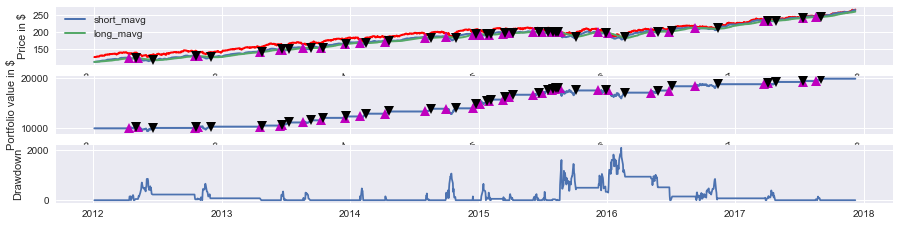

In [29]:

if __name__ == "__main__":
    # Obtain daily bars of AAPL from Yahoo Finance for the period
    # 1st Jan 1990 to 1st Jan 2002 - This is an example from ZipLine
    bars = pd.read_csv('SPY.csv',index_col=['Date'],parse_dates=True)
    start='2012-01-01'
    end='2017-12-08'
    bars=bars.loc[start:end]
    symbol='SPY'
    # Create a Moving Average Cross Strategy instance with a short moving
    # average window of 100 days and a long window of 400 days
    mac = MovingAverageCrossStrategy(symbol, bars, short_window=5, long_window=34)
    signals = mac.generate_signals()
    #signals.to_csv('/Users/aybarsatalay/Desktop/Python/sig.csv')
    

    # Create a portfolio of SPY, with $100,000 initial capital

    portfolio = MarketOnClosePortfolio(symbol, bars, signals, initial_capital=10000.0)
    returns = portfolio.backtest_portfolio()
    rets=returns['returns'].dropna()
    pnl=returns['total'].dropna()
    sharpe_ratio=annualised_sharpe(rets,N=252)
    drawdown, max_dd, dd_duration = create_drawdowns(pnl)
    metrics = [("Sharpe Ratio", "%0.2f" % sharpe_ratio),
                 ("Max Drawdown", "%0.2f" % (max_dd * 100.0)),
                 ("Drawdown Duration", "%d" % dd_duration)]
    print (metrics)

    # Plot two charts to assess trades and equity curve
    fig = plt.figure()
    fig.patch.set_facecolor('white')     # Set the outer colour to white
    ax1 = fig.add_subplot(311,  ylabel='Price in $')
    
    # Plot the AAPL closing price overlaid with the moving averages
    bars['Close'].plot(ax=ax1, color='r', lw=2.)
    signals[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2.)

    # Plot the "buy" trades against AAPL
    ax1.plot(signals.ix[signals.positions == 1.0].index, 
             signals.short_mavg[signals.positions == 1.0],
             '^', markersize=10, color='m')

    # Plot the "sell" trades against AAPL
    ax1.plot(signals.ix[signals.positions == -1.0].index, 
             signals.short_mavg[signals.positions == -1.0],
             'v', markersize=10, color='k')

    # Plot the equity curve in dollars
    ax2 = fig.add_subplot(312, ylabel='Portfolio value in $')
    returns['total'].plot(ax=ax2, lw=2.)

    # Plot the "buy" and "sell" trades against the equity curve
    ax2.plot(returns.ix[signals.positions == 1.0].index, 
             returns.total[signals.positions == 1.0],
             '^', markersize=10, color='m')
    ax2.plot(returns.ix[signals.positions == -1.0].index, 
             returns.total[signals.positions == -1.0],
             'v', markersize=10, color='k')
    ax3 = fig.add_subplot(313, ylabel='Drawdown')
    
    ax3.plot(drawdown)



    # Plot the figure
    plt.show()


In [7]:
from collections import defaultdict

short = range(2, 20, 2)
long = range(20, 60, 2)
dd = defaultdict(dict)
for lg in long:
    for sh in short:
            mac = MovingAverageCrossStrategy(symbol, bars, short_window=sh, long_window=lg)
            signals = mac.generate_signals()
    #signals.to_csv('/Users/aybarsatalay/Desktop/Python/sig.csv')
    

    # Create a portfolio of AAPL, with $100,000 initial capital

            portfolio = MarketOnClosePortfolio(symbol, bars, signals, initial_capital=100000.0)
            returns = portfolio.backtest_portfolio()
            rets=returns['returns'].dropna()
            #print (rets)
    
            dd[lg][sh]=annualised_sharpe(rets,N=252)

ddf = pd.DataFrame(dd)
ddf.index.name = 'short'
ddf.columns.name = 'Long'

print (ddf)

Long      20     22     24     26     28     30     32     34     36     38  \
short                                                                         
2      0.197  0.231  0.180  0.196  0.230  0.237  0.240  0.217  0.209  0.214   
4      0.184  0.215  0.205  0.200  0.196  0.199  0.222  0.239  0.244  0.234   
6      0.226  0.232  0.181  0.184  0.174  0.182  0.196  0.182  0.155  0.168   
8      0.249  0.202  0.175  0.168  0.165  0.158  0.150  0.171  0.165  0.195   
10     0.218  0.169  0.167  0.143  0.160  0.146  0.152  0.167  0.169  0.182   
12     0.190  0.158  0.190  0.204  0.163  0.175  0.174  0.146  0.143  0.161   
14     0.183  0.155  0.155  0.154  0.144  0.135  0.132  0.158  0.133  0.151   
16     0.139  0.099  0.155  0.131  0.085  0.132  0.128  0.143  0.173  0.186   
18     0.098  0.166  0.148  0.102  0.084  0.080  0.071  0.148  0.196  0.185   

Long      40     42     44     46     48     50     52     54     56     58  
short                                               

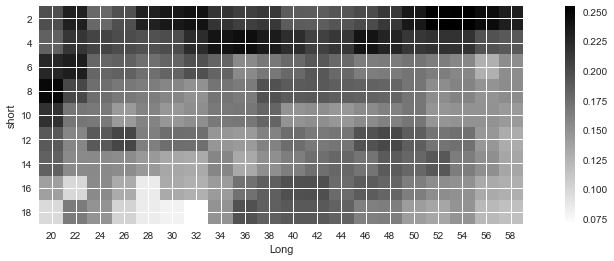

In [8]:
import matplotlib.pyplot as plt

def heatmap(df, cmap=plt.cm.gray_r):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    axim = ax.imshow(df.values, cmap=cmap, interpolation='nearest')
    ax.set_xlabel(df.columns.name)
    ax.set_xticks(np.arange(len(df.columns)))
    ax.set_xticklabels(list(df.columns))
    ax.set_ylabel(df.index.name)
    ax.set_yticks(np.arange(len(df.index)))
    ax.set_yticklabels(list(df.index))
    plt.colorbar(axim)
    
a=heatmap(ddf)
plt.show()

'''Heat map depicts different parameter values(long/short MA ratio) under which maximum sharpe ratio can be achieved'''